<a href="https://colab.research.google.com/github/armelyara/drgreen/blob/main/drgreen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is about Dr Green machine learning model for plant classification. We will use this model to build a mobile app which can give you the scientific name, local name, common name and therapeutic vertues.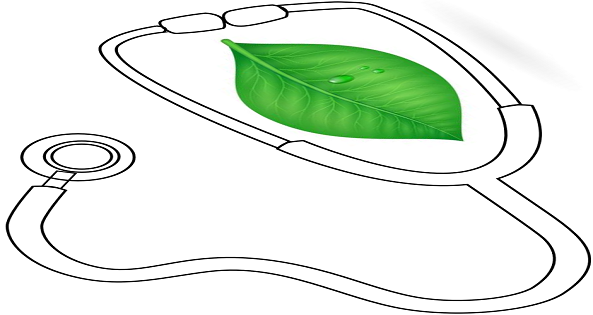

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf

import os
import numpy as np
import PIL
from PIL import Image
import glob
import matplotlib.pyplot as plt
import zipfile

from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop

In [2]:
print(tf.__version__)

2.12.0



**DATA PROCESSING**

In [2]:
#Path to download dataset
local_zip = 'plantes.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('plantes')
zip_ref.close()

#Define the datasate path
base_dir = 'plantes/rename/'


In [3]:
# Directory with our training horse pictures
train_art_dir = os.path.join('plantes/rename/artemisia')

# Directory with our training human pictures
train_cari_dir = os.path.join('plantes/rename/carica')
# Directory with our training human pictures
train_goya_dir = os.path.join('plantes/rename/goyavier')
# Directory with our training human pictures
train_kink_dir = os.path.join('plantes/rename/kinkeliba')

In [4]:
train_art_names = os.listdir(train_art_dir)
print(train_art_names[:10])
train_cari_names = os.listdir(train_cari_dir)
print(train_cari_names[:10])
train_goya_names = os.listdir(train_goya_dir)
print(train_goya_names[:10])
train_kink_names = os.listdir(train_kink_dir)
print(train_kink_names[:10])

['arte_28.jpg', 'arte_219.jpg', 'arte_236.jpg', 'arte_176.jpg', 'arte_260.jpg', 'arte_124.jpg', 'arte_117.jpg', 'arte_223.jpg', 'arte_148.jpg', 'arte_100.jpg']
['159.1401984731-149651-450.jpg', 'car_50.jpg', '323.figuier--goutte-d-or--p-image-33989-grande.jpg', '95.2019-01-06_jardin.jpg', 'car_41.jpg', '5.35763114-simple-feuille-fra_C3_AEche-carica-de-papaye.jpg', '462.ficuscarica_1.jpg', '533.220px-Carica_papaya_fl_fem.jpg', '167.papayer-100147.jpg', '512.figuier-col-de-dame-blanc-ficus-carica.jpg']
['28.fruit-d-usine-de-psidium-guajava-130185933.jpg', '521.citrus-ichangensis-papeda.jpg', '472.psidium-goyavier-cattley19.jpg', '201.goyave-de-b_C3_A9b_C3_A9-sur-l-arbre.jpg', '281.psidium-guajava1.jpg', '367.GBDB_photo_3357.jpg', '16.psidium-guajava-fruit-vert.jpg', '199.goyave_fraise.jpg', '442.Puya_mirabilis.jpg', '543.ponpon-soldat-e1460847138558.jpg']
['299.gc000007767.jpg', '358.moringa-oleifera-184428-650-325.jpg', '500.medium.jpg', '335.tude-prospective-pour-lamenagement-dune-fort

In [5]:
print('total training artemisia images:', len(os.listdir(train_art_dir)))
print('total training carica images:', len(os.listdir(train_cari_dir)))
print('total training goyavier images:', len(os.listdir(train_goya_dir)))
print('total training kinkeliba images:', len(os.listdir(train_kink_dir)))

total training artemisia images: 250
total training carica images: 357
total training goyavier images: 218
total training kinkeliba images: 293


In [6]:
#Parameters for the loader
batch_size = 32
img_height = 300
img_width = 300

In [7]:
#Split the dataset in training & validation set
train_pl = tf.keras.utils.image_dataset_from_directory(
  base_dir,
  subset="training",
  validation_split=0.2,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


val_pl = tf.keras.utils.image_dataset_from_directory(
  base_dir,
  subset="validation",
  validation_split=0.2,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1115 files belonging to 4 classes.
Using 892 files for training.
Found 1115 files belonging to 4 classes.
Using 223 files for validation.


In [8]:
#Find the class names using class_names attribut
class_names = train_pl.class_names
print(class_names)

['artemisia', 'carica', 'goyavier', 'kinkeliba']


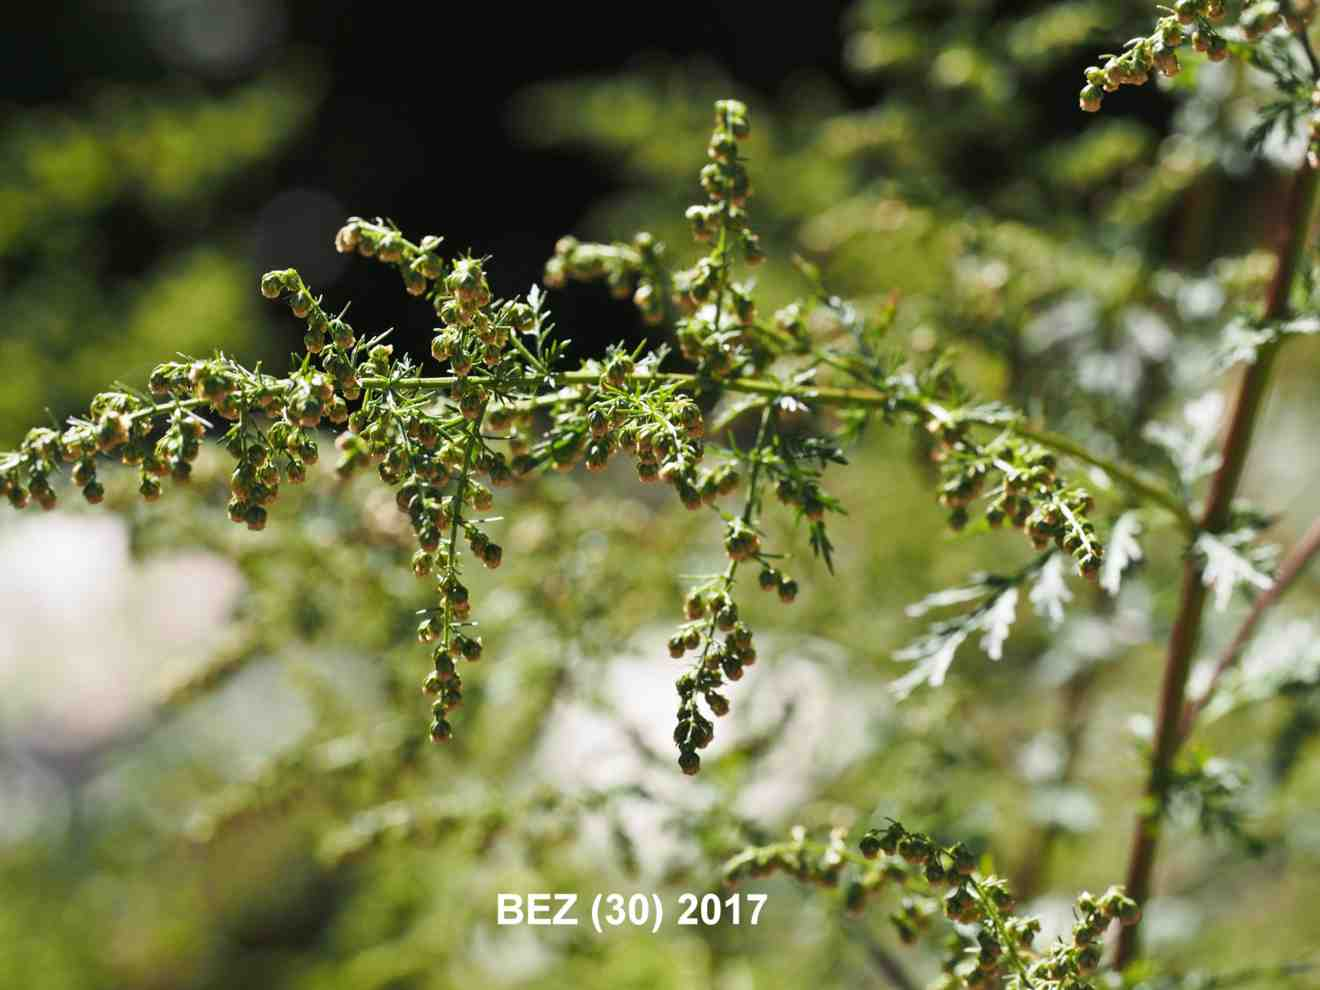

In [9]:
#Show any artemisia image
artemisia = list(glob.glob(base_dir + 'artemisia/*'))
PIL.Image.open(str(artemisia[1]))

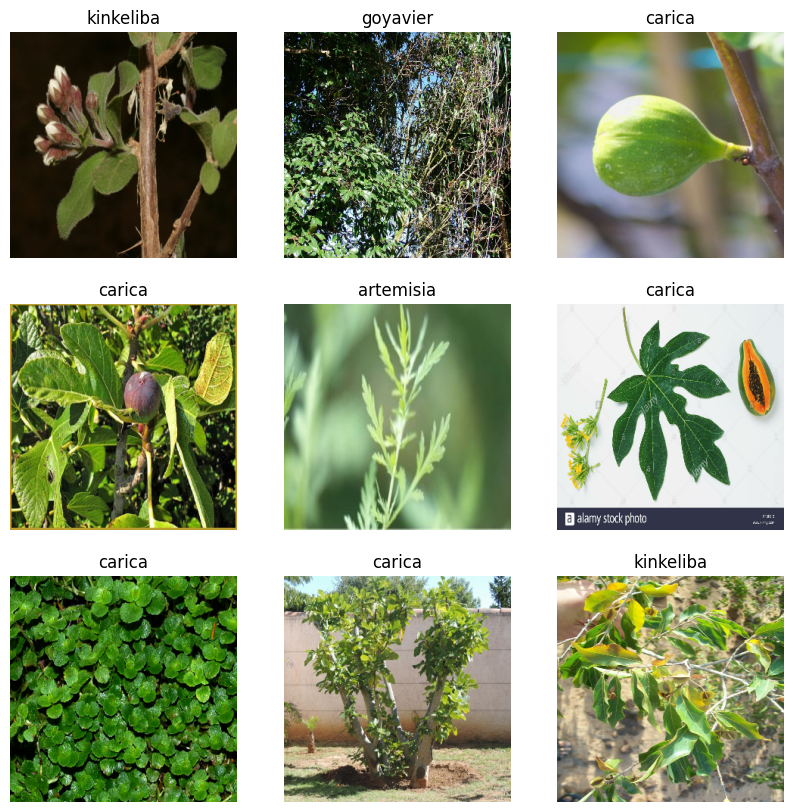

In [10]:
#Visualize the data. Here you will see the first nine images from the training dataset

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for images, labels in train_pl.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
#Count the total number of image in the dataset
image_count = len(list(glob.glob(base_dir + '*/*')))

print(image_count)

1118


In [12]:
#Iterate over the dataset and retrieve batches of images
for image_batch, labels_batch in train_pl:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 300, 300, 3)
(32,)


In [13]:
#Overlaps data preprocessing and model execution while training
AUTOTUNE = tf.data.AUTOTUNE

train_pl = train_pl.cache().prefetch(buffer_size=AUTOTUNE)
val_pl = val_pl.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
#Standardize Data
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [15]:
normalized_ds = train_pl.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [16]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

In [17]:
num_classes = 4

model = tf.keras.models.Sequential([
    data_augmentation,
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer='l2'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(num_classes, activation='sigmoid')
])

In [18]:
#Show model parameters
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)       

In [19]:
model.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(),
              #optimizer='adam',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['acc'])

In [41]:
# Add early stopping to the model
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5)

epochs = 8
history = model.fit(
      train_pl,
      validation_data=val_pl,
      epochs=epochs,
      callbacks=[early_stopping]
      )

Epoch 1/8
28/28 [==============================] - 118s 4s/step - loss: 0.7255 - acc: 0.7388 - val_loss: 1.5841 - val_acc: 0.5022
Epoch 2/8
28/28 [==============================] - 120s 4s/step - loss: 0.6463 - acc: 0.7892 - val_loss: 1.7994 - val_acc: 0.5247
Epoch 3/8
28/28 [==============================] - 120s 4s/step - loss: 0.6608 - acc: 0.7679 - val_loss: 1.7127 - val_acc: 0.5650
Epoch 4/8
28/28 [==============================] - 120s 4s/step - loss: 0.6624 - acc: 0.7892 - val_loss: 1.5565 - val_acc: 0.5112
Epoch 5/8
28/28 [==============================] - 120s 4s/step - loss: 0.6188 - acc: 0.7859 - val_loss: 1.4622 - val_acc: 0.5605
Epoch 6/8
28/28 [==============================] - 117s 4s/step - loss: 0.6685 - acc: 0.7780 - val_loss: 1.5630 - val_acc: 0.5785
Epoch 7/8
28/28 [==============================] - 113s 4s/step - loss: 0.6664 - acc: 0.7691 - val_loss: 1.5440 - val_acc: 0.5426
Epoch 8/8
28/28 [==============================] - 116s 4s/step - loss: 0.6519 - acc: 0.78

Build a sequential model with Keras API.

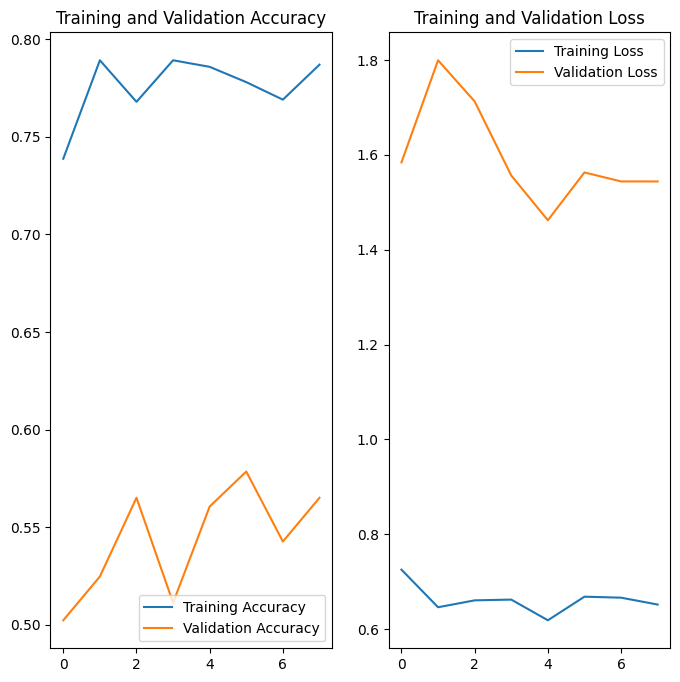

In [42]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
#Test our model with another image unseen in training and validation set
import numpy as np

from google.colab import files
from keras.utils import load_img, img_to_array

uploaded=files.upload()

for fn in uploaded.keys():

  # predicting images
  path='/content/' + fn
  img= load_img(path, target_size=(180, 180))

  x=img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])

  plantes = model.predict(images, batch_size=32)

  print(plantes[0])

  if plantes.any():
    print(fn + "is an artemisia")

  else:
    print(fn + "is a carica")


Saving Alchornea cordifolia.jpg to Alchornea cordifolia.jpg


ValueError: ignored

In [43]:
score = model.evaluate(val_pl, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.5439292192459106
Test accuracy: 0.5650224089622498


In [44]:
#Convert and save model in TensorFlow Lite
saved_model_dir = 'save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('drgreen.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
#Download model
from google.colab import files

files.download('drgreen.tflite')
files.download('plants.txt')